
# Landlab Landslide Probability Model with Saturation 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:200px;padding:20px">   


<br />
This Jupyter Notebook runs the Landlab LandslideProbability component on a synthetic 
Landlab grid using four depth to water table options to replace recharge options described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 
This notebook performs the following functions:<br >
* Import libraries and set HydroShare variables<br />
* Create a grid and data fields used to calculate landslide probability<br />
* Specify Depth to Water Table Distributions to compare four options<br /> 
* Run LandslideProbability function from Landlab landslide component<br /> 
* Compare the sensitivity based on four Depth to Water Table options<br /> 



## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [3]:
#import Python utilities for calculating and plotting
import six
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
hs=hydroshare.hydroshare()
homedir = os.getcwd()
print('Data will be loaded from and saved to:'+homedir)
os.chdir('/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents')
print(homedir)

# Import Landlab libraries
import landslide_probability
from landslide_probability_20191122 import LandslideProbability
from landlab import RasterModelGrid
from landlab import imshow_grid_at_node

from landlab.io.netcdf import read_netcdf
from landlab.io.netcdf import NETCDF4_EXAMPLE_FILE
import netCDF4 as nc4


Successfully established a connection with HydroShare
Successfully established a connection with HydroShare
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/kernelapp.py"

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## Create a grid and data fields used to calculate landslide probability

This example uses a synthetic model domain. As a first example, make a synthetic grid with 5 rows and 4 columns space 0.2 units apart.   <br /> 
##### Synthetic Grid Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the rows, columns, and spacing of your choice.  

In [8]:
#data4 = nc4.Dataset('dwt_historic.nc', 'r')
lon = np.arange(45,103,3)
lat = np.arange(-30,29,3)
dtw = np.arange(0,5,.2)
f = nc4.Dataset('test1.nc','w', format='NETCDF4')
testgrp = f.createGroup('Test_data')
testgrp.createDimension('lon',len(lon))
testgrp.createDimension('lat',len(lat))
testgrp.createDimension('dtw',len(dtw))
longitude = testgrp.createVariable('Longitude','i4','lon')
latitude = testgrp.createVariable('Latitude', 'i4', 'lat')
depth_to_water = testgrp.createVariable('GroundWaterDepth','f4','dtw')
longitude[:]=lon
latitude[:]=lat
depth_to_water=dtw
f.decription = "example netCDF of depth to groundwater"
f.close()

In [12]:
import xarray as xr
import numpy as np
import pandas as pd

temp = 15 + 8 * np.random.randn(3, 3, 2)  # time, y, x
precip = 10 * np.random.rand(3, 3, 2)  # time, y, x
lat = [100, 101, 102]
lon = [10, 11]

ds = xr.Dataset({'temperature': (['time', 'y', 'x'],  temp),
                 'precipitation': (['time', 'y', 'x'], precip)},
                coords={'x': (['x'], lon),
                        'y': (['y'], lat),
                        'time': pd.date_range('2014-09-06', periods=3)})


In [13]:
ds

<xarray.Dataset>
Dimensions:        (time: 3, x: 2, y: 3)
Coordinates:
  * y              (y) int64 100 101 102
  * x              (x) int64 10 11
  * time           (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
Data variables:
    precipitation  (time, y, x) float64 6.685 2.546 9.583 0.8443 2.112 2.845 ...
    temperature    (time, y, x) float64 12.37 9.511 13.09 23.97 10.93 12.04 ...

In [11]:
testgrp

RuntimeError: NetCDF: Not a valid ID

In [2]:
grid = RasterModelGrid((5, 4), spacing=(0.2, 0.2))

Confirm the size of the grid

In [3]:
grid.number_of_nodes

20

To see what the grid id of our nodes are, execute the command below.  However, note that this command gives you the rows of the grid, but these are technically up-side-down from how the RasterModelGrid nodes are numbered (e.g,. node id 0 is at the bottom left corner of the grid). 

In [4]:
grid.nodes

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

In [5]:
core_nodes = grid.core_nodes
core_nodes

array([ 5,  6,  9, 10, 13, 14])

Check the list of data inputs that the component needs.

In [6]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Review the details of what each variable represents.

In [7]:
LandslideProbability._var_doc

{'landslide__probability_of_failure': 'number of times FS is <=1 out of number of iterations user selected',
 'soil__density': 'wet bulk density of soil',
 'soil__internal_friction_angle': 'critical angle just before failure due to friction between particles',
 'soil__maximum_total_cohesion': 'maximum of combined root and soil cohesion at node',
 'soil__mean_relative_wetness': 'Indicator of soil wetness; relative depth perched water table within the soil layer',
 'soil__mean_watertable_depth': 'mean distance to groundwater table from distribution of depths to groundwater or saturated soils',
 'soil__minimum_total_cohesion': 'minimum of combined root and soil cohesion at node',
 'soil__mode_total_cohesion': 'mode of combined root and soil cohesion at node',
 'soil__probability_of_saturation': 'number of times relative wetness is >=1 out of number of iterations user selected',
 'soil__saturated_hydraulic_conductivity': 'mode rate of water transmitted through soil - provided if transmissi

Check the units of each variable.

In [8]:
LandslideProbability._var_units

{'landslide__probability_of_failure': 'None',
 'soil__density': 'kg/m3',
 'soil__depth_to_groundwater': 'm',
 'soil__internal_friction_angle': 'degrees',
 'soil__maximum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mean_relative_wetness': 'None',
 'soil__mean_watertable_depth': 'm',
 'soil__minimum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mode_total_cohesion': 'Pa or kg/m-s2',
 'soil__probability_of_saturation': 'None',
 'soil__saturated_hydraulic_conductivity': 'm/day',
 'soil__thickness': 'm',
 'soil__transmissivity': 'm2/day',
 'topographic__slope': 'tan theta',
 'topographic__specific_contributing_area': 'm'}

Now we will create the required fields for the landslide component and add data as fields to the grid.  Thus, the data arrays will need to be as the length of the number of nodes.<br /> 
##### Data Fields Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the data inputs of your choice.  

In [9]:
gridnodes = grid.number_of_nodes
grid_size = grid.number_of_nodes

grid['node']['soil__density']= \
         2000. * np.ones(gridnodes)

grid['node']['soil__internal_friction_angle']= \
         np.sort(np.random.randint(26, 37, gridnodes))

grid['node']['soil__mode_total_cohesion']= \
         np.sort(np.random.randint(30, 900, gridnodes))
    
scatter_dat = np.random.randint(1, 10, gridnodes)    
grid['node']['soil__maximum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] + scatter_dat

grid['node']['soil__minimum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] - scatter_dat

grid['node']['soil__thickness']= \
         np.sort(np.random.randint(1, 10, gridnodes))

grid['node']['soil__transmissivity']= \
         np.sort(np.random.randint(5, 20, gridnodes),-1)
        
grid['node']['topographic__slope'] = np.random.rand(gridnodes)

grid['node']['topographic__specific_contributing_area']= \
         np.sort(np.random.randint(30, 900, gridnodes))

Let's see what one of these fields (slope) looks like on the grid.

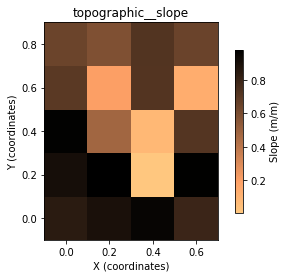

In [10]:
plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')

In [11]:
np.mean(grid['node']['soil__thickness'])

4.4500000000000002

In [12]:
grid['node']['soil__thickness']

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9])

In [128]:

n=50

Demin_value = 2 
Demax_value = 5
distribution1 = 'uniform'
depth_dist = np.random.uniform(Demin_value, Demax_value,size=n)
depth_dist
mean_depth=np.mean(depth_dist)
print(mean_depth)
grid['node']['soil__mean_watertable_depth']=mean_depth* np.ones(gridnodes)
print(grid['node']['soil__mean_watertable_depth'])

3.43317067096
[ 3.43317067  3.43317067  3.43317067  3.43317067  3.43317067  3.43317067
  3.43317067  3.43317067  3.43317067  3.43317067  3.43317067  3.43317067
  3.43317067  3.43317067  3.43317067  3.43317067  3.43317067  3.43317067
  3.43317067  3.43317067]


In [129]:
meanDTW=3.2

In [180]:
print(grid['node']['soil__mean_watertable_depth'])
print(grid['node']['soil__thickness'])

[ 3.37344309  3.37344309  3.37344309  3.37344309  3.37344309  3.37344309
  3.37344309  3.37344309  3.37344309  3.37344309  3.37344309  3.37344309
  3.37344309  3.37344309  3.37344309  3.37344309  3.37344309  3.37344309
  3.37344309  3.37344309]
[1 1 1 1 2 2 2 2 3 4 5 6 6 6 7 7 7 8 9 9]


In [181]:
hw=grid['node']['soil__thickness']-grid['node']['soil__mean_watertable_depth']
hw

array([-2.37344309, -2.37344309, -2.37344309, -2.37344309, -1.37344309,
       -1.37344309, -1.37344309, -1.37344309, -0.37344309,  0.62655691,
        1.62655691,  2.62655691,  2.62655691,  2.62655691,  3.62655691,
        3.62655691,  3.62655691,  4.62655691,  5.62655691,  5.62655691])

In [182]:
hw[np.where(hw<0)] = grid['node']['soil__thickness'][np.where(hw<0)]
hw

array([ 1.        ,  1.        ,  1.        ,  1.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  3.        ,  0.62655691,
        1.62655691,  2.62655691,  2.62655691,  2.62655691,  3.62655691,
        3.62655691,  3.62655691,  4.62655691,  5.62655691,  5.62655691])

In [183]:
grid['node']['soil__thickness']

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9])

## Relative wetness calculated from Depth to Water Table

In [184]:

n=50
Demin_value = 2 
Demax_value = 5
distribution1 = 'uniform'
depth_dist = np.random.uniform(Demin_value, Demax_value,size=n)
depth_dist
mean_depth=np.mean(depth_dist)
print(mean_depth)
grid['node']['soil__mean_watertable_depth']=mean_depth* np.ones(gridnodes)
print(grid['node']['soil__mean_watertable_depth'])

3.61157550207
[ 3.6115755  3.6115755  3.6115755  3.6115755  3.6115755  3.6115755
  3.6115755  3.6115755  3.6115755  3.6115755  3.6115755  3.6115755
  3.6115755  3.6115755  3.6115755  3.6115755  3.6115755  3.6115755
  3.6115755  3.6115755]


In [185]:
grid['node']['relative_wetness_d']= hw/grid['node']['soil__thickness']
grid['node']['relative_wetness_d']

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.15663923,
        0.32531138,  0.43775949,  0.43775949,  0.43775949,  0.51807956,
        0.51807956,  0.51807956,  0.57831961,  0.62517299,  0.62517299])

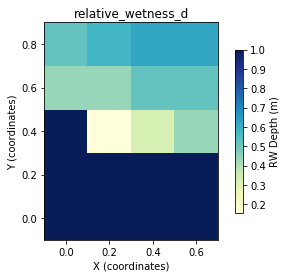

In [186]:
plt.figure('Water Table Depth')
imshow_grid_at_node(grid,'relative_wetness_d', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='RW Depth', var_units='m')
plt.savefig('rw.png')

## Relative wetness calculated from Recharge

In [168]:
n=50
Remin_value = 10
Remax_value = 40
distribution1 = 'uniform'
recharge_dist = np.random.uniform(Remin_value, Remax_value,size=n)
print(recharge_dist)# values in mm
mean_recharge=np.mean(recharge_dist)/1000#convert mm to meters
print(mean_recharge)
grid['node']['soil__mean_recharge']=mean_recharge* np.ones(gridnodes)
print(grid['node']['soil__mean_recharge'])

[ 18.87675929  19.09875764  20.67667464  34.30906245  27.3277027
  12.25831839  12.34738299  21.13860833  32.99773152  30.66050279
  31.23947064  33.01630198  18.61458139  26.44768846  26.30057921
  32.18897504  38.70611707  18.33969834  33.79845018  29.79911646
  27.40713613  33.24639338  38.32097399  11.10074254  14.42200308
  32.68861695  12.51374059  25.48371102  16.5958233   18.22887112
  31.05521449  10.9057832   36.19958284  23.33436866  25.07179882
  26.20143891  29.36632884  20.3456976   13.03322472  19.5513681
  15.04426354  26.68399538  19.54085893  38.74201534  38.97202834
  28.60377642  28.52491803  39.56135694  36.61849454  32.95209847]
0.0257691820737
[ 0.02576918  0.02576918  0.02576918  0.02576918  0.02576918  0.02576918
  0.02576918  0.02576918  0.02576918  0.02576918  0.02576918  0.02576918
  0.02576918  0.02576918  0.02576918  0.02576918  0.02576918  0.02576918
  0.02576918  0.02576918]


In [169]:
water_input=grid['node']['soil__mean_recharge']*grid['node']['topographic__specific_contributing_area']
water_input

array([  2.08730375,   2.16461129,   2.19038048,   3.04076348,
         4.40653013,   4.63845277,   5.72075842,   8.14306154,
         8.22036908,   8.76152191,   9.84382755,  11.00344075,
        12.78151431,  13.2195904 ,  14.63689542,  14.6626646 ,
        19.35265574,  20.02265447,  22.93457205,  22.96034123])

In [170]:
capacity=grid['node']['soil__transmissivity']*np.sin(np.arctan(grid['node']['topographic__slope']))
capacity

array([  3.2446477 ,   3.34334703,   4.15065168,   3.74040702,
         4.04277917,   4.90801874,   0.0338816 ,   6.29452377,
         6.97378609,   4.79042643,   1.0104573 ,   7.01280953,
         8.04573038,   2.78077827,   8.81679858,   2.3102498 ,
         9.26228669,   9.13730127,  10.61140775,   9.84766408])

In [171]:
grid['node']['relative_wetness_r']=water_input/capacity
grid['node']['relative_wetness_r']

array([   0.64330674,    0.64743841,    0.52771966,    0.81294989,
          1.08997547,    0.94507642,  168.84557246,    1.29367397,
          1.17875269,    1.82896492,    9.74195299,    1.56904885,
          1.58860833,    4.75391747,    1.66011453,    6.34678751,
          2.08940366,    2.19130943,    2.16131286,    2.33155203])

In [172]:
np.place(grid['node']['relative_wetness_r'], grid['node']['relative_wetness_r'] > 1, 1.0)

grid['node']['relative_wetness_r']

array([ 0.64330674,  0.64743841,  0.52771966,  0.81294989,  1.        ,
        0.94507642,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

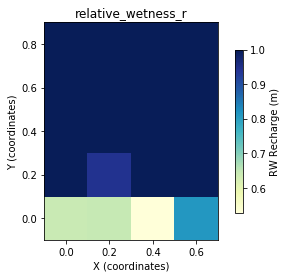

In [173]:
plt.figure('Recharge')
imshow_grid_at_node(grid,'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='RW Recharge', var_units='m')
plt.savefig('rw.png')

### Create a netCDF

In [191]:
lon = np.arange(45,103,3)
lat = np.arange(-30,29,3)
dtw = np.arange(0,5,.2)
f = nc4.Dataset('test.nc','w', format='NETCDF4')
testdata = f.createGroup('Test_data')
testgrp.createDimension('lon',len(lon))
testgrp.createDimension('lat',len(lat))
testgrp.createDimension('dtw',len(dtw))
longitude = testgrp.createVariable('Longitude','i4','lon')
latitude = testgrp.createVariable('Latitude', 'i4', 'lat')
depth_to_water = testgrp.createVariable('GroundWaterDepth','f4','dtw')
longitude[:]=lon
latitude[:]=lat
depth_to_water=dtw
f.decription = "example netCDF of depth to groundwater"
f.close()

NameError: name 'nc4' is not defined

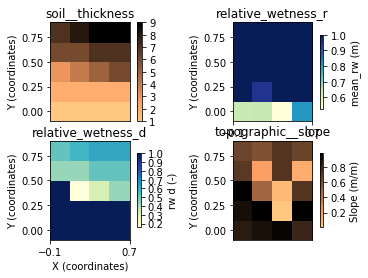

In [187]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'soil__thickness', plot_name='soil (m)',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean_rw', var_units='m')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_d', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='rw d', var_units='-')

ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')


### Results: relative wetness is a function of soil thickness given uniform depth to groundwater (assume steady state to depth to groundwater (dtw) is equivelent to depth of water recharged )

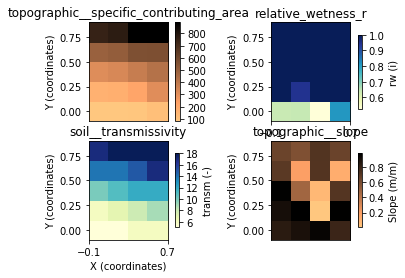

In [190]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'topographic__specific_contributing_area', plot_name='area',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='rw', var_units='i')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__transmissivity', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='transm', var_units='-')

ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')



### Results: relative wetness is a function of contributing area given uniform recharge (assume steady state depth of water is equivelent to depth to groundwater (dtw) )

Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. 

This simulation generates a probability value for each core node. 

In [ ]:
LS_prob1_soil__probability_of_saturation = grid.at_node['soil__mean_relative_wetness']
grid.at_node['soil__mean_relative_wetness']

In [ ]:
LS_prob1_soil__probability_of_saturation = grid.at_node['soil__probability_of_saturation']
grid.at_node['soil__probability_of_saturation']

In [ ]:
LS_prob1_soil__mean_watertable_depth = grid.at_node['soil__mean_watertable_depth']
grid.at_node['soil__mean_watertable_depth']

In [ ]:
LS_prob1_probability_of_failure = grid.at_node['landslide__probability_of_failure']
grid.at_node['landslide__probability_of_failure']